# The Battle of Neighborhoods - Part 2

## Definition of the Problem
After the completion of a certain Data Science course, an young and brave Brazilian data scientist is flooded with job offers from all over the world. After thoughtful consideration, he realizes he really likes where he currently lives and would like to have the same kind of venues around him wherever the job is. <br>
From the job offers, he selects a few cities that seem interesting and sets out to compare his current city's attractions to the neighborhoods of each new possible location, trying to identify similarities. <br>
Two approaches will be used:
1. Based on the similarity, we will present a list of the three neighborhoods from each city that better match his current location, display a metric of the similarity between them and present three new venue types what he should try out at the new location.
2. A clustering technique will be used to group all the neighborhoods into sets and then classify the current location. This way he can see if the ones that better match his current neighborhood, even if they are all in the same city. This would mean that particular city is a better fit over all. 

## Definition of the Data

1. The first input needed from the user is his current location, so that we can create the standard we will use to compare the cities. *The format is 'Neighborhood, City, Country'.*
2. The second input we need is the list of possible cities. *The format is a list with each 'City, Country'.*
3. From these, we have to manually find and webscrape the list of neighborhoods or districts and their coordinates. 
4. With all the coordinates, we will use the Foursquare API to explore 100 venues around a 1km radius from the center of each neighborhood. 
5. We'll construct a Dataframe where each row is a neighborhood from a different city and each column is the percentage of each type of venue.
6. First we will compute the correlation between each row and the data from the current location. The end result is a list with the 3 top neighborhoods that better match, the correlation, and the top 3 venue types taht are present at the new location, but not at the current one.
7. The second approach is to use clustering to identify a group of neighborhoods that is closer to the original location. We'll try a different number of clusters to optimize the separation. 
8. We'll fit the current location data into the model and present the list of neighborhoods that are in the same cluster.

## Starting the code by importing the necessary libraries

In [113]:
#to get the coordinates
!pip3 install geopy
from geopy.geocoders import Nominatim
import time
from pprint import pprint

#to work with the data
import numpy as np 
import pandas as pd

#to handle webscraping
!pip install bs4
from bs4 import BeautifulSoup 

#to understand the data from Foursquare
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#to show the data
import matplotlib.pyplot as plt 
%matplotlib inline

#to do the clustering
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist

print('All libraries imported!')

All libraries imported!


## Input from the user

In [2]:
#current location ['Neighborhood','City', 'Country']
current_location=['Copacabana','Rio de Janeiro','Brazil']
#list of the cities
#just to list the other cities, we have to manually webscrape the list of neighborhoods from each one
# ['City','Country']
list_of_cities=[['Porto Alegre','Brazil'],
                ['Wellington','New Zealand'],
                ['Stockholm','Sweden'],
                ['Vancouver', 'Canada']    
]

## Webscraping for the list of neighborhoods for each of the cities

We'll need to manually find and extract the list of neighborhoods from each city. BeautifulSoup is the library used for this.

### 1. Porto Alegre

There is a list of the neighborhoods of the city of Porto Alegre available at the Wikipedia page, in Portuguese. We are going to process that information into a dataframe for future use.<br>
<a href="https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Porto_Alegre">List of neighborhoods</a>

In [3]:
#retrieving the webpage
url='https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Porto_Alegre'
html_data=requests.get(url).text
soup = BeautifulSoup(html_data,"html5lib") 

In [16]:
#get the list
table_contents=[]
table=soup.findAll('table')[2]
for row in table.findAll('td'):
    for cell in row.findAll('a'):
        table_contents.append((cell.text).split('<'))
#turn list of lists into flat list
porto_alegre = [ item for elem in table_contents for item in elem]

#removing unwanted items (numbers)
for idx, ele in enumerate(porto_alegre): 
    porto_alegre[idx] = ele.replace('(', '')
    
for idx, ele in enumerate(porto_alegre): 
    porto_alegre[idx] = ele.replace(')', '')

porto_alegre = [item for item in porto_alegre if not item.isdigit()]
porto_alegre

48

### 2. Wellington

There is a list of the neighborhoods of the city of Wellngton available at their City Council webpage. We are going to process that information into a dataframe for future use.<br>
<a href="https://wellington.govt.nz/your-council/elections/wellington-city-wards/maps-by-ward-community-board-and-suburb">List of neighborhoods</a>

In [5]:
#retrieving the webpage
url='https://wellington.govt.nz/your-council/elections/wellington-city-wards/maps-by-ward-community-board-and-suburb'
html_data=requests.get(url).text
soup = BeautifulSoup(html_data,"html5lib") 

In [18]:
#get the list
table_contents=[]
table=soup.findAll('li')[131:194]
for row in table:
    table_contents.append(row.text)

wellington=table_contents
wellington

12

### 3. Stockholm

There is a list of the districts of the city of Stockholm available at the Wikipedia page. We are going to process that information into a dataframe for future use.<br>
<a href="https://en.wikipedia.org/wiki/Category:Districts_of_Stockholm">List of districts</a>

In [7]:
#retrieving the webpage
url='https://en.wikipedia.org/wiki/Category:Districts_of_Stockholm'
html_data=requests.get(url).text
soup = BeautifulSoup(html_data,"html5lib") 

In [19]:
#get the list
table_contents=[]
table=soup.findAll('li')[2:70]
for row in table:
    for cell in row.findAll('a'):
        table_contents.append((cell.text).split('<'))

#turn list of lists into flat list
stockholm = [ item for elem in table_contents for item in elem]

#getting rid of unnecessary text
for ii in range(len(stockholm)):
    if stockholm[ii][-9:]=="Stockholm":
        stockholm[ii]=stockholm[ii][:-11]
    if stockholm[ii][-10:]=="(district)":
        stockholm[ii]=stockholm[ii][:-11]
#found a problem with one of the names!
    if stockholm[ii][-10:]=="Birkastaden":
        stockholm[ii]="Birkastad"
    
stockholm

107

### 4. Vancouver

There is a list of the neighborhoods of the city of Vancouver available at the Wikipedia page. We are going to process that information into a dataframe for future use.<br>
<a href="https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver">List of neighborhoods</a>

In [9]:
#retrieving the webpage
url='https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver'
html_data=requests.get(url).text
soup = BeautifulSoup(html_data,"html5lib") 

In [20]:
#get the list
table_contents=[]
table=soup.findAll('li')[5:27]
for row in table:
    table_contents.append(row.findAll('a')[0])

#turn list of lists into flat list
vancouver = [ item for elem in table_contents for item in elem]
vancouver

22

## Finding the coordinates for each of the neighborhoods

Now that we have the name of the neighborhoods from each of the cities and the name of current location of the user we will create a dataframe with the name of the country, name of the city, name of the neighborhood and its coordinates (latitude and longitude).

In [11]:
column_names=['Country','City','Neighborhood','Latitude','Longitude']
df_cities=pd.DataFrame(columns=column_names)
df_cities=df_cities.append([{'Country': current_location[2],
                   'City': current_location[1],
                   'Neighborhood': current_location[0],
                   'Latitude': 0,
                   'Longitude': 0} ]               
                 )
df_cities

,Country,City,Neighborhood,Latitude,Longitude
0,Brazil,Rio de Janeiro,Copacabana,0,0


In [12]:
for ii in range(len(porto_alegre)):
    df_cities=df_cities.append([{'Country': 'Brazil',
                   'City': 'Porto Alegre',
                   'Neighborhood': porto_alegre[ii],
                   'Latitude': 0,
                   'Longitude': 0} ]  
        )
for ii in range(len(wellington)):
    df_cities=df_cities.append([{'Country': 'New Zealand',
                   'City': 'Wellington',
                   'Neighborhood': wellington[ii],
                   'Latitude': 0,
                   'Longitude': 0} ]  
        )

for ii in range(len(stockholm)):
    df_cities=df_cities.append([{'Country': 'Sweden',
                   'City': 'Stockholm',
                   'Neighborhood': stockholm[ii],
                   'Latitude': 0,
                   'Longitude': 0} ]  
        )

for ii in range(len(vancouver)):
    df_cities=df_cities.append([{'Country': 'Canada',
                   'City': 'Vancouver',
                   'Neighborhood': vancouver[ii],
                   'Latitude': 0,
                   'Longitude': 0} ]  
        )

print('We have a total of ',df_cities.shape[0],' neighborhoods.')
df_cities=df_cities.reset_index()
df_cities.drop(columns=["index"],inplace=True)
df_cities.head()

We have a total of  239  neighborhoods.


,Country,City,Neighborhood,Latitude,Longitude
0,Brazil,Rio de Janeiro,Copacabana,0,0
1,Brazil,Porto Alegre,Aberta dos Morros,0,0
2,Brazil,Porto Alegre,Agronomia,0,0
3,Brazil,Porto Alegre,Anchieta,0,0
4,Brazil,Porto Alegre,Arquipélago,0,0


We are ready to get the coordinates for each of our neighborhoods. We define a function to retrieve the geolocation for them. This function is unreliable, so we will be loading data that was obtain through a lucky run of the function.

In [23]:
app = Nominatim(user_agent="fekjgrweg")
def get_location_by_address(address):
    """This function returns a location as raw from an address
    will repeat until success"""
    time.sleep(1)
    try:
        return app.geocode(address).raw
    except:
        return get_location_by_address(address)

In [24]:
df_cities.to_csv('dfcities.csv')

In [ ]:
for ii in range(df_cities.shape[0]):
    if ii%10==0:
        print(ii)
    address = [df_cities.iloc[ii,2],df_cities.iloc[ii,1],df_cities.iloc[ii,0]]
    location = get_location_by_address(address)
    df_cities.iloc[ii,-2] = location["lat"]
    df_cities.iloc[ii,-1] = location["lon"]
df_cities.head()

In [21]:
df_cities=pd.read_csv('dfcities2.csv',index_col=0)
df_cities

,Country,City,Neighborhood,Latitude,Longitude
0,Brazil,Rio de Janeiro,Copacabana,-22.971964,-43.184343
1,Brazil,Porto Alegre,Aberta dos Morros,-30.160022,-51.197486
2,Brazil,Porto Alegre,Agronomia,-30.069267,-51.149217
3,Brazil,Porto Alegre,Anchieta,-29.975652,-51.174903
4,Brazil,Porto Alegre,Arquipélago,-29.992760,-51.226618
...,...,...,...,...,...
234,Canada,Vancouver,Strathcona,49.277693,-123.088539
235,Canada,Vancouver,Sunset,49.219093,-123.091665
236,Canada,Vancouver,Victoria-Fraserview,49.218979,-123.063816
237,Canada,Vancouver,West End,49.284131,-123.131795


## Get venues from Foursquare

We are ready to get the data from the Foursquare API. We want to collect the list of up to 100 venues close to the geocoordinates from each neighborhood. We start by setting our credentials.

In [ ]:
CLIENT_ID = '****' # your Foursquare ID
CLIENT_SECRET = '****' # your Foursquare Secret
ACCESS_TOKEN = '*' # your FourSquare Access Token
VERSION = '20210331'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

We set up a function to retrieve the information from Foursquare and return a new dataframe where each row is a different venue from the neighborhoods.

In [30]:
def getNearbyVenues(city, names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for city, name, lat, lng in zip(city,names, latitudes, longitudes):
        print(city, name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [150]:
all_venues=getNearbyVenues(df_cities['City'],df_cities['Neighborhood'],df_cities['Latitude'],df_cities['Longitude'])
all_venues.head()

Rio de Janeiro Copacabana
Porto Alegre Aberta dos Morros
Porto Alegre Agronomia
Porto Alegre Anchieta
Porto Alegre Arquipélago
Porto Alegre Auxiliadora
Porto Alegre Azenha
Porto Alegre Bela Vista
Porto Alegre Belém Novo
Porto Alegre Belém Velho
Porto Alegre Boa Vista
Porto Alegre Boa Vista do Sul
Porto Alegre Bom Jesus
Porto Alegre Bom Fim
Porto Alegre Camaquã
Porto Alegre Campo Novo
Porto Alegre Cascata
Porto Alegre Cavalhada
Porto Alegre Centro
Porto Alegre Chácara das Pedras
Porto Alegre Chapéu do Sol
Porto Alegre Cidade Baixa
Porto Alegre Coronel Aparício Borges
Porto Alegre Cristal
Porto Alegre Cristo Redentor
Porto Alegre Espírito Santo
Porto Alegre Farrapos
Porto Alegre Farroupilha
Porto Alegre Floresta
Porto Alegre Glória
Porto Alegre Guarujá
Porto Alegre Higienópolis
Porto Alegre Hípica
Porto Alegre Humaitá
Porto Alegre Independência
Porto Alegre Ipanema
Porto Alegre Jardim Botânico
Porto Alegre Jardim Carvalho
Porto Alegre Jardim Dona Leopoldina
Porto Alegre Jardim Floresta
P

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rio de Janeiro,Copacabana,-22.971964,-43.184343,Praia de Copacabana,-22.972441,-43.183436,Beach
1,Rio de Janeiro,Copacabana,-22.971964,-43.184343,Windsor California Hotel,-22.972704,-43.185707,Hotel
2,Rio de Janeiro,Copacabana,-22.971964,-43.184343,Hotel Sesc Copacabana,-22.973265,-43.187299,Hotel
3,Rio de Janeiro,Copacabana,-22.971964,-43.184343,Bibi Sucos,-22.972092,-43.186564,Juice Bar
4,Rio de Janeiro,Copacabana,-22.971964,-43.184343,Bar & Champanheria Copacabana,-22.974220,-43.186296,Beach Bar


In [151]:
print('There are {} uniques categories.'.format(len(all_venues['Venue Category'].unique())))

There are 421 uniques categories.


## Analyzing Neighborhoods

We have up to 100 venues from each Neighborhood, with hundreds of different categories. We will create a new dataframe, with each row corresponding to a venue and each column is a different type of venue. 

In [156]:
# one hot encoding
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

#moving one of the venue categories
all_onehot['Neighborhoods']=all_onehot['Neighborhood']
all_onehot.drop(columns=['Neighborhood'],inplace=True)
# add neighborhood column back to dataframe
all_onehot['City'] = all_venues['City'] 
all_onehot['Neighborhood'] = all_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = list(all_onehot.columns[-2:]) + list(all_onehot.columns[:-2])
all_onehot = all_onehot[fixed_columns]
all_onehot.head()

,City,Neighborhood,Acai House,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,...,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Neighborhoods
0,Rio de Janeiro,Copacabana,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rio de Janeiro,Copacabana,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rio de Janeiro,Copacabana,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rio de Janeiro,Copacabana,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rio de Janeiro,Copacabana,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will collapse the information from all venues to every neighborhood. The end result will be the proportion of each type of venue that is present at each neighborhood.

In [160]:
all_grouped = all_onehot.groupby(by=['City','Neighborhood']).mean().reset_index()
all_grouped.head()

,City,Neighborhood,Acai House,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,...,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Neighborhoods
0,Porto Alegre,Aberta dos Morros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,Porto Alegre,Agronomia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,Porto Alegre,Anchieta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,Porto Alegre,Arquipélago,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,Porto Alegre,Auxiliadora,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
print('We have ', all_grouped.shape[0],' neighborhoods, with ',all_grouped.shape[1]-2,' types of venues.')

We have  233  neighborhoods, with  421  types of venues.


There were 6 neighborhoods with no venues at all.

## Correlation between Neighborhoods

Our first approach to help our poor Data Scientist is to compute the correlation between the venue data from the current location with all the other neighborhoods. We'll add a new column to the dataframe with the Pearson correlation between each row and the first one (the current location).

In [162]:
all_grouped[all_grouped['City']=='Rio de Janeiro']


,City,Neighborhood,Acai House,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,...,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Neighborhoods
85,Rio de Janeiro,Copacabana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.010989,0.0,0.0,0.010989,0.0,0.0,0.0,0.0,0.0


In this new dataframe, the current location is row number 85.

In [163]:
all_grouped['Correlation']=0.

x_current = np.array(all_grouped.iloc[85,3:].astype(float))
for ii in range(all_grouped.shape[0]):
    y_new = np.array(all_grouped.iloc[ii,3:].astype(float))
    all_grouped.iloc[ii,-1] = np.corrcoef(x_current, y_new)[0][1]

In [164]:
all_grouped['Correlation'].head()

0    0.192798
1    0.141169
2    0.203390
3   -0.020960
4    0.242751
Name: Correlation, dtype: float64

With the correlations, we'll see the best fits for each of the cities, along with the three venue types that have the larger proportion and are not present in the current location.

### 1. Porto Alegre

In [166]:
top_portoalegre=all_grouped[all_grouped['City']=='Porto Alegre'].sort_values(by=['Correlation'],ascending=False).head(3)
top1_portoalegre=top_portoalegre[0:1]
top2_portoalegre=top_portoalegre[1:2]
top3_portoalegre=top_portoalegre[2:]

empty_column1=[]
empty_column2=[]
empty_column3=[]
for ii in range(2,all_grouped.shape[1]):
    if  top1_portoalegre.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column1.append(all_grouped.columns[ii])
    if  top2_portoalegre.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column2.append(all_grouped.columns[ii])
    if  top3_portoalegre.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column3.append(all_grouped.columns[ii])

top1_portoalegre.drop(empty_column1[:-1], axis=1, inplace=True)
top2_portoalegre.drop(empty_column2[:-1], axis=1, inplace=True)
top3_portoalegre.drop(empty_column3[:-1], axis=1, inplace=True)



/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [168]:
top1_portoalegre

,City,Neighborhood,Art Gallery,Arts & Crafts Store,Auditorium,Bar,Beer Bar,Beer Store,Bookstore,Buffet,...,Spa,Sports Bar,Street Fair,Swiss Restaurant,Tapas Restaurant,Theater,Track,Vegetarian / Vegan Restaurant,Women's Store,Correlation
20,Porto Alegre,Cidade Baixa,0.01,0.02,0.01,0.1,0.01,0.02,0.02,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.471352


In [169]:
top2_portoalegre

,City,Neighborhood,Amphitheater,Athletics & Sports,Bar,Beer Bar,Beer Store,Bookstore,Buffet,Business Service,...,Salad Place,Salon / Barbershop,Skate Park,South American Restaurant,Sporting Goods Shop,Supermarket,Vegetarian / Vegan Restaurant,Waterfront,Women's Store,Correlation
61,Porto Alegre,Praia de Belas,0.01,0.01,0.09,0.01,0.01,0.01,0.03,0.01,...,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.414434


In [170]:
top3_portoalegre

,City,Neighborhood,Art Gallery,Athletics & Sports,Bar,Beer Bar,Beer Garden,Bistro,Bookstore,Buffet,...,Sandwich Place,Snack Place,Southern Brazilian Restaurant,Spa,Supermarket,Thai Restaurant,Veterinarian,Wine Shop,Wings Joint,Correlation
27,Porto Alegre,Floresta,0.012987,0.012987,0.051948,0.025974,0.012987,0.012987,0.012987,0.025974,...,0.012987,0.012987,0.012987,0.025974,0.012987,0.012987,0.012987,0.012987,0.012987,0.396419


1. The first neighborhood from Porto Alegre, Cidade Baixa, has a correlation of 0.47. The 3 new types of venues are 'Arts & Crafts store', 'Beer store' and 'Bookstore'.
2. The second neighborhood, Praia de Belas, has a correlation of 0.41. The 3 new types of venues are 'Bar', 'Buffet' and 'Salad Place'.
3. The third neighborhood, Floresta, has a correlation of 0.40. The 3 new types of venues are 'Bar', 'Beer bar' and 'Buffet'.

### 2. Wellington

In [171]:
top_wellington=all_grouped[all_grouped['City']=='Wellington'].sort_values(by=['Correlation'],ascending=False).head(3)
top1_wellington=top_wellington[0:1]
top2_wellington=top_wellington[1:2]
top3_wellington=top_wellington[2:]

empty_column1=[]
empty_column2=[]
empty_column3=[]
for ii in range(2,all_grouped.shape[1]):
    if  top1_wellington.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column1.append(all_grouped.columns[ii])
    if  top2_wellington.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column2.append(all_grouped.columns[ii])
    if  top3_wellington.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column3.append(all_grouped.columns[ii])

top1_wellington.drop(empty_column1[:-1], axis=1, inplace=True)
top2_wellington.drop(empty_column2[:-1], axis=1, inplace=True)
top3_wellington.drop(empty_column3[:-1], axis=1, inplace=True)




/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [172]:
top1_wellington

,City,Neighborhood,Bar,Hotel,River,Correlation
188,Wellington,Horokiwi,0.333333,0.333333,0.333333,0.625507


In [173]:
top2_wellington

,City,Neighborhood,Bar,Bike Rental / Bike Share,Brewery,Café,Chinese Restaurant,Convenience Store,Falafel Restaurant,Farmers Market,...,Pier,Playground,Pool,Seafood Restaurant,Southern / Soul Food Restaurant,Supermarket,Tapas Restaurant,Thai Restaurant,Vietnamese Restaurant,Correlation
215,Wellington,Oriental Bay,0.053333,0.013333,0.013333,0.093333,0.066667,0.026667,0.013333,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.026667,0.013333,0.455498


In [174]:
top3_wellington

,City,Neighborhood,Art Gallery,Athletics & Sports,BBQ Joint,Bar,Boat or Ferry,Café,Chocolate Shop,Cocktail Bar,...,Salad Place,Sandwich Place,Seafood Restaurant,Stadium,Supermarket,Tennis Court,Toy / Game Store,Turkish Restaurant,Vietnamese Restaurant,Correlation
218,Wellington,Pipitea,0.014493,0.014493,0.014493,0.043478,0.014493,0.043478,0.014493,0.014493,...,0.028986,0.028986,0.028986,0.014493,0.014493,0.014493,0.014493,0.014493,0.028986,0.427678


1. The first neighborhood from Wellington, Horokiwi, has a correlation of 0.63. The 3 new types of venues are 'Bar', 'Hotel' and 'River'.
2. The second neighborhood, Oriental Bay, has a correlation of 0.46. The 3 new types of venues are 'Café', 'Chinese restaurant' and 'Bar'.
3. The third neighborhood, Pipitea, has a correlation of 0.43. The 3 new types of venues are 'Café', 'Bar' and 'Vietnamese Restaurant'.

### 3. Stockholm

In [175]:
top_stockholm=all_grouped[all_grouped['City']=='Stockholm'].sort_values(by=['Correlation'],ascending=False).head(3)
top1_stockholm=top_stockholm[0:1]
top2_stockholm=top_stockholm[1:2]
top3_stockholm=top_stockholm[2:]

empty_column1=[]
empty_column2=[]
empty_column3=[]
for ii in range(2,all_grouped.shape[1]):
    if  top1_stockholm.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column1.append(all_grouped.columns[ii])
    if  top2_stockholm.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column2.append(all_grouped.columns[ii])
    if  top3_stockholm.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column3.append(all_grouped.columns[ii])

top1_stockholm.drop(empty_column1[:-1], axis=1, inplace=True)
top2_stockholm.drop(empty_column2[:-1], axis=1, inplace=True)
top3_stockholm.drop(empty_column3[:-1], axis=1, inplace=True)

/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [176]:
top1_stockholm

,City,Neighborhood,Art Gallery,Bar,Beer Bar,Beer Garden,Bookstore,Breakfast Spot,Café,Candy Store,...,Salad Place,Scandinavian Restaurant,Seafood Restaurant,Tapas Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Correlation
132,Stockholm,Riddarholmen,0.01,0.04,0.01,0.01,0.01,0.02,0.05,0.01,...,0.01,0.08,0.01,0.01,0.01,0.01,0.03,0.01,0.03,0.524632


In [177]:
top2_stockholm

,City,Neighborhood,Art Gallery,Art Museum,Bar,Beer Bar,Beer Garden,Bookstore,Boutique,Breakfast Spot,...,Salad Place,Scandinavian Restaurant,Seafood Restaurant,Spiritual Center,Tapas Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Wine Bar,Correlation
106,Stockholm,Gamla stan,0.01,0.01,0.02,0.01,0.01,0.02,0.01,0.01,...,0.01,0.1,0.01,0.01,0.01,0.03,0.01,0.01,0.03,0.513101


In [178]:
top3_stockholm

,City,Neighborhood,Café,Forest,Hotel,Indian Restaurant,Sandwich Place,Shopping Mall,Supermarket,Tennis Stadium,Thai Restaurant,Train Station,Correlation
150,Stockholm,Älvsjö,0.117647,0.058824,0.176471,0.058824,0.058824,0.058824,0.117647,0.058824,0.058824,0.058824,0.482045


1. The first neighborhood from Stockholm, Riddarholmen, has a correlation of 0.52. The 3 new types of venues are 'Scandinavian Restaurant', 'Café' and 'Bar'. 
2. The second neighborhood, Gamla stan 	, has a correlation of 0.51. The 3 new types of venues are 'Theater', 'Bookstore' and 'Wine bar'.
3. The third neighborhood, Älvsjö, has a correlation of 0.48. The 3 new types of venues are 'Hotel', 'Supermarket' and 'Café'.

### 4. Vancouver

In [179]:
top_vancouver=all_grouped[all_grouped['City']=='Vancouver'].sort_values(by=['Correlation'],ascending=False).head(3)
top1_vancouver=top_vancouver[0:1]
top2_vancouver=top_vancouver[1:2]
top3_vancouver=top_vancouver[2:]

empty_column1=[]
empty_column2=[]
empty_column3=[]
for ii in range(2,all_grouped.shape[1]):
    if  top1_vancouver.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column1.append(all_grouped.columns[ii])
    if  top2_vancouver.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column2.append(all_grouped.columns[ii])
    if  top3_vancouver.iloc[0,ii]==0 or all_grouped.iloc[0,ii]!=0:
        empty_column3.append(all_grouped.columns[ii])

top1_vancouver.drop(empty_column1[:-1], axis=1, inplace=True)
top2_vancouver.drop(empty_column2[:-1], axis=1, inplace=True)
top3_vancouver.drop(empty_column3[:-1], axis=1, inplace=True)

/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [180]:
top1_vancouver

,City,Neighborhood,Art Gallery,Belgian Restaurant,Bookstore,Boutique,Breakfast Spot,Brewery,Building,Café,...,Seafood Restaurant,Shopping Mall,Taco Place,Theater,Toy / Game Store,Trade School,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio,Correlation
155,Vancouver,Downtown,0.01,0.01,0.02,0.01,0.02,0.01,0.01,0.02,...,0.03,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.501553


In [181]:
top2_vancouver

,City,Neighborhood,American Restaurant,Bookstore,Café,Clothing Store,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Dessert Shop,...,Sculpture Garden,Seafood Restaurant,South Indian Restaurant,Spanish Restaurant,Thai Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio,Correlation
174,Vancouver,West End,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.03,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.437037


In [182]:
top3_vancouver

,City,Neighborhood,American Restaurant,Arts & Crafts Store,BBQ Joint,Bank,Bar,Bookstore,Breakfast Spot,Bubble Tea Shop,...,Seafood Restaurant,Spa,Tennis Court,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Women's Store,Yoga Studio,Correlation
157,Vancouver,Fairview,0.03,0.02,0.01,0.01,0.02,0.02,0.04,0.01,...,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.02,0.232422


1. The first neighborhood from Vancouver, Downtown, has a correlation of 0.50. The 3 new types of venues are 'Seafood restaurant' and a tie for several others.
2. The second neighborhood, West End, has a correlation of 0.44. The 3 new types of venues are 'Dessert shop', 'Bookstore' and a tie for several others.
3. The third neighborhood, Fairview, has a correlation of 0.23. The 3 new types of venues are 'Breafast spot', 'Theater' and 'Bookstore'.

## Clustering approach

We are going to create groups using the proportion of venue types to try to find neighborhoods that are alike the current location. We will try different number of groups to see the best distribution.

In [183]:
all_grouped_clustering = all_grouped.drop(['City','Neighborhood','Correlation'], 1)

distortions=[]
# run k-means clustering for different number of k
for ii in range(2,200):
    kmeans = KMeans(n_clusters=ii, random_state=0).fit(all_grouped_clustering)
    distortions.append(sum(np.min(cdist(all_grouped_clustering, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / all_grouped_clustering.shape[0])



Let's look at the plot of the evaluation of the distances to the cluster centers.

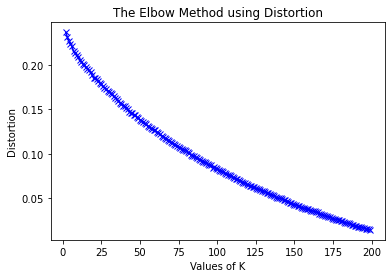

In [184]:
plt.plot(range(2,200), distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

From this plot, we can see that the optimum number of clusters is not very clear. For sake of the exercise, let's look again in the range 10-20.

In [187]:
distortions=[]
# run k-means clustering for different number of k
for ii in range(10,50):
    kmeans = KMeans(n_clusters=ii, random_state=0).fit(all_grouped_clustering)
    distortions.append(sum(np.min(cdist(all_grouped_clustering, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / all_grouped_clustering.shape[0])



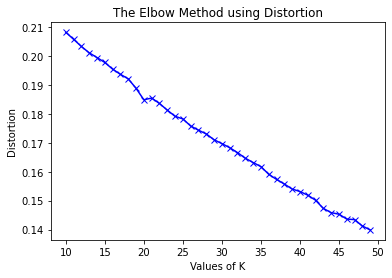

In [188]:
plt.plot(range(10,50), distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

For lack of a better option, **k=20**.

In [189]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(all_grouped_clustering)
all_grouped['Cluster']=kmeans.labels_

In what cluster is the current location?

In [190]:
print('The current location is in cluster: ',all_grouped.iloc[85,-1])

The current location is in cluster:  4


What other neighborhoods are in the same cluster?

In [193]:
cluster=all_grouped[all_grouped['Cluster']==all_grouped.iloc[85,-1]].sort_values(by=['Correlation'],ascending=False)
cluster[['City','Neighborhood','Correlation']]

,City,Neighborhood,Correlation
85,Rio de Janeiro,Copacabana,1.000000
132,Stockholm,Riddarholmen,0.524632
106,Stockholm,Gamla stan,0.513101
155,Vancouver,Downtown,0.501553
215,Wellington,Oriental Bay,0.455498
174,Vancouver,West End,0.437037
218,Wellington,Pipitea,0.427678
129,Stockholm,Norrmalm,0.426942
208,Wellington,Mount Victoria,0.420843
145,Stockholm,Södermalm,0.402839


These are the neighborhoods from any city that were clustered with the current location.

## Discussion

We can compare the results of the two approaches. 
Let's take a look at the neighborhoods inside cluster 4 with the highest correlation to the current location.
1. **Riddarholmen** is also the highest correlation in Stockholm, so the two methods seem to agree this is a good choice.
2. **Gamla stan** is also the second in Stockholm. Again, a good choice, with a correlation a bit smaller (0.525 to 0.513).
3. **Downtown** is the highest correlation in Vancouver, and third in the cluster. 
4. **Oriental Bay** is the second highest correlation in Wellington, but the first one to appear in cluster 4, in fourth place.
5. **Cascata** is the first option from Porto Alegre, but it is not in a high rank, and it didn't show in the top 3 for its city.

## Conclusion

Our Data Scientist wants to find a new place to work based on the assumption that the activites are similar to the ones he is used to. From the list of cities supplied, we analised the top attractions from each neighborhood and presented the ones that best fit that requirement.

Everything else being equal, our suggestion to the Data Scientist is to pick, in this order:
1. Stockholm: either Riddarholmen or Gamla Stan;
2. Vancouver: Downtown
3. Wellington: Oriental Bay